In [1]:
import torch
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.torch_version
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
main_path = '/kaggle/input/isic-2024-challenge' if iskaggle else 'data/isic-2024-challenge'

In [4]:
train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv' if iskaggle else 'data/isic-2024-challenge/train-metadata.csv'
test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv' if iskaggle else 'data/isic-2024-challenge/test-metadata.csv'

train_metadata_df = pd.read_csv(train_metadata_path)
test_metadata_df = pd.read_csv(test_metadata_path)

print(len(train_metadata_df))

C:\Users\abdfa\AppData\Local\Temp\ipykernel_26920\3275392473.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv(train_metadata_path)


401059


In [5]:
import sklearn.model_selection as train_test_split

train_size = 0.8
# Splitting the train dataset into positive and negative samples and saving them in separate dataframes
postive_samples = train_metadata_df[train_metadata_df['target'] == 1]
negative_samples = train_metadata_df[train_metadata_df['target'] == 0]
print(f"Positive samples: {postive_samples.shape}")
print(f"Negative samples: {negative_samples.shape}")

Positive samples: (393, 55)
Negative samples: (400666, 55)


In [6]:

# Splitting each type of samples into train and validation sets
train_positive_samples, val_positive_samples = train_test_split.train_test_split(postive_samples,test_size=1-train_size)
train_negative_samples, val_negative_samples = train_test_split.train_test_split(negative_samples,test_size=1-train_size)
print(f"Train positive samples: {train_positive_samples.shape}")
print(f"Train negative samples: {train_negative_samples.shape}")
print(f"Val positive samples: {val_positive_samples.shape}")
print(f"Val negative samples: {val_negative_samples.shape}")


Train positive samples: (314, 55)
Train negative samples: (320532, 55)
Val positive samples: (79, 55)
Val negative samples: (80134, 55)


In [7]:

# Concatenating the positive and negative samples to get the train and validation sets
train_metadata_df = pd.concat([train_positive_samples, train_negative_samples])
val_metadata_df = pd.concat([val_positive_samples, val_negative_samples])
print(f"Train samples: {train_metadata_df.shape}")
print(f"Val samples: {val_metadata_df.shape}")
print(f"Test samples: {test_metadata_df.shape}")


Train samples: (320846, 55)
Val samples: (80213, 55)
Test samples: (3, 44)


In [8]:
import h5py
from io import BytesIO

train_hdf5_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5' if iskaggle else 'data/isic-2024-challenge/train-image.hdf5'
test_hdf5_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5' if iskaggle else 'data/isic-2024-challenge/test-image.hdf5'

In [9]:
train_hdf5_file = h5py.File(train_hdf5_path,'r')
test_hdf5_file = h5py.File(test_hdf5_path,'r')

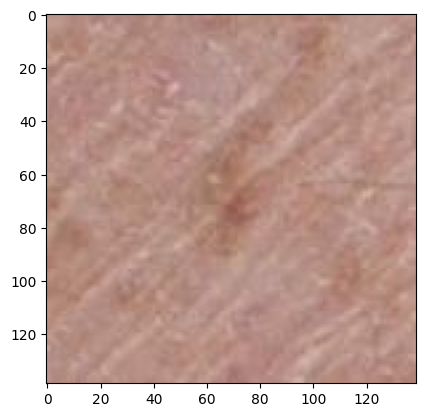

In [10]:
image = Image.open(BytesIO(train_hdf5_file['ISIC_0015670'][()]))
plt.imshow(image)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, hdf5_file, metadata_df,target=None, transform=None):
        self.hdf5_file = hdf5_file
        self.metadata_df = metadata_df
        self.image_ids = metadata_df['isic_id']
        self.labels = target
        self.transform = transform

        self.mean_of_color_channels = None  # Initialize as None
        self.std_of_color_channels = None   # Initialize as None
        # self._calculate_stats()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids.iloc[idx]
        image = Image.open(BytesIO(self.hdf5_file[image_id][()]))

        # Calculate mean and standard deviation if not already done
        # if self.mean_of_color_channels is None or self.std_of_color_channels is None:
        #     self._calculate_stats()

        # Apply transformation with calculated statistics
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return image, label
        else:
            return image
   

In [12]:
# HyperParameters
dim = 50
batch_size = 256

In [13]:
train_transform = transforms.Compose([ 
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

train_transform_modified = transforms.Compose([ 
    transforms.Resize((dim, dim)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

test_transform = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

In [14]:
train_dataset = CustomDataset(train_hdf5_file,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
val_dataset = CustomDataset(train_hdf5_file,val_metadata_df,target=val_metadata_df['target'],transform=train_transform)
test_dataset = CustomDataset(test_hdf5_file,test_metadata_df,transform=test_transform)

In [15]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=True)

In [16]:
from sklearn.metrics import roc_curve, auc

def calculate_partial_auc_by_tpr(y_true, y_scores, max_tpr=0.8):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Limit the TPR to the specified maximum
    mask = tpr <= max_tpr
    fpr, tpr = fpr[mask], tpr[mask]
    
    # Calculate the partial AUC
    partial_auc = auc(fpr, tpr)
    
    # Normalize the partial AUC to the range [0, 1]
    partial_auc /= max_tpr
    
    return partial_auc

In [17]:
class Model(nn.Module):
    def __init__(self,num_classes,device,dim = 32,num_epochs = 20,learning_rate = 0.001,early_stopping = False):
        super().__init__()
        self.num_of_classes = num_classes
        self.device = device
        self.dim = dim
        # Debugging
        self.DEBUG = True
        # Hyperparameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        # History while Training
        self.model_loss_history = []
        self.model_train_acc_history = []
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_val_pauc_history = []
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.BCELoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'binary', average='macro').to(self.device)
        self.precision = Precision(task= 'binary', average='macro').to(self.device)
        self.recall = Recall(task= 'binary', average='macro').to(self.device)
        # Model Architecture
        self.feature_extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(            
            nn.Linear(20000,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(self.device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns accuracy, precision and recall
        '''
        self.eval()
        y_pred = []
        y_actual = []
        with torch.no_grad():
            for images, labels in data_loader:
                
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                labels = labels.unsqueeze(1).float()
                self.accuracy(outputs, labels)
                self.precision(outputs, labels)
                self.recall(outputs, labels)

                y_pred.extend(outputs.cpu().numpy())
                y_actual.extend(labels.cpu().numpy())
        
        partial_auc = calculate_partial_auc_by_tpr(y_actual, y_pred)


        return self.accuracy.compute(), self.precision.compute(), self.recall.compute(), partial_auc, y_pred, y_actual
    
    def train_model(self, train_loader, val_loader):
        
        last_accuracy = -100
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self(images)
                labels = labels.unsqueeze(1).float()
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%1000 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall, val_pauc, _ , _ = self.eval_val(val_loader)
            train_acc, _, _, _, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_val_pauc_history.append(val_pauc)
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val PAUC: {val_pauc}')
            
            if val_acc > last_accuracy:
                last_accuracy = val_acc
            elif self.early_stopping:
                break
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        axs[1, 2].plot(self.model_val_pauc_history)
        axs[1, 2].set_title('Model Partial AUC')
        axs[1, 2].set_xlabel('Epochs')
        axs[1, 2].set_ylabel('Partial AUC')
        

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(),type(self).__name__+'.pth')

    def print_summary(self):
        summary(self, (3, self.dim, self.dim))

In [18]:
num_of_classes = 2
cnn = Model(num_classes=num_of_classes, 
            device=device, 
            dim=dim, 
            num_epochs=2, 
            learning_rate=0.001,
            early_stopping=False)
cnn.to(device)
cnn.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,432
         MaxPool2d-2           [-1, 32, 25, 25]               0
           Flatten-3                [-1, 20000]               0
            Linear-4                    [-1, 1]          20,001
           Sigmoid-5                    [-1, 1]               0
Total params: 22,433
Trainable params: 22,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.92
Params size (MB): 0.09
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


In [19]:
cnn.train_model(train_loader=train_loader,val_loader=val_loader)

TypeError: h5py objects cannot be pickled

In [ ]:
cnn_acc , cnn_precision, cnn_recall , cnn_pauc, y_pred, y_actual = cnn.eval_val(val_loader)
print(f"Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}")

Accuracy: 0.9990094304084778, Precision: 0.30434781312942505, Recall: 0.0080924853682518


In [ ]:
print(f"Partial AUC: {cnn_pauc}")
print(y_pred, y_actual)

Partial AUC: 0.2204630029510696
[array([0.00015996], dtype=float32), array([0.00039031], dtype=float32), array([0.00096476], dtype=float32), array([0.00045889], dtype=float32), array([0.00023324], dtype=float32), array([0.0008532], dtype=float32), array([0.00403333], dtype=float32), array([0.00018885], dtype=float32), array([0.00094224], dtype=float32), array([1.0512907e-05], dtype=float32), array([0.00040578], dtype=float32), array([6.80752e-05], dtype=float32), array([0.00040233], dtype=float32), array([5.9600436e-05], dtype=float32), array([0.01422743], dtype=float32), array([0.00016831], dtype=float32), array([2.3021346e-05], dtype=float32), array([0.0002893], dtype=float32), array([0.0004156], dtype=float32), array([3.327932e-05], dtype=float32), array([0.00140945], dtype=float32), array([0.00066096], dtype=float32), array([3.066892e-05], dtype=float32), array([0.00034111], dtype=float32), array([0.00099466], dtype=float32), array([9.159378e-05], dtype=float32), array([0.00165678]

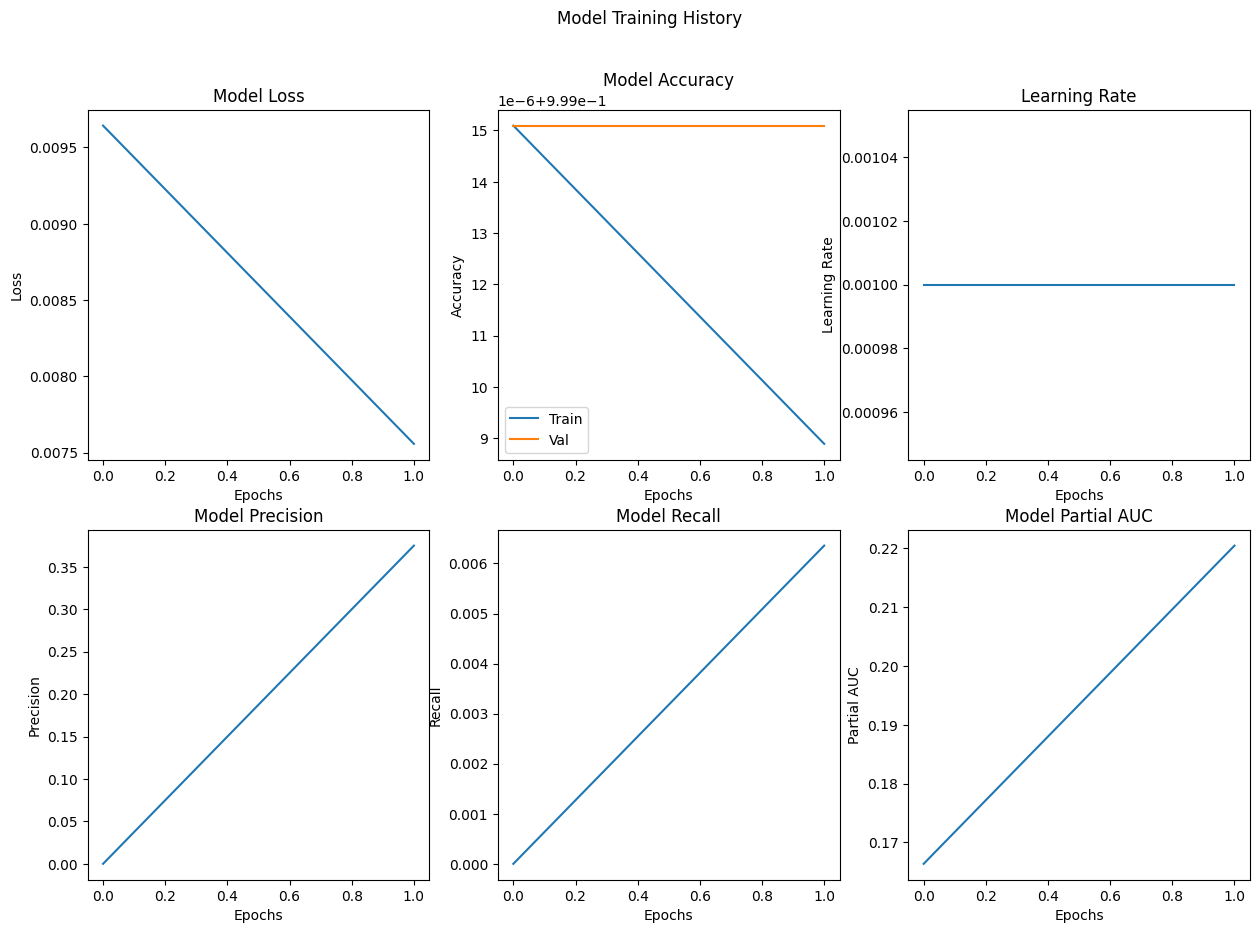

In [ ]:
cnn.plot_history()

In [ ]:
cnn.save_model()